In [64]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter 
from sklearn.linear_model import LinearRegression
from string import punctuation
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxnbf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df = pd.read_csv("cleaned.csv")
df.head()

,annual_salary,description
0,48880.0,many industries hurt last years people still n...
1,39500.0,Provide clerical administrative support manage...
2,100000.0,United Staffing Solutions partnering one bigge...
3,38000.0,looking responsible Administrative Assistant p...
4,144000.0,REMOTE WORK HOME COMMISSION PER ORDER REMOTE W...


In [66]:
def tokenize(desc):
    tokens = nltk.word_tokenize(desc)

    # filter out all tokens of length 1?
    return tokens

df["description"] = df["description"].apply(tokenize)

df.head()

,annual_salary,description
0,48880.0,"[many, industries, hurt, last, years, people, ..."
1,39500.0,"[Provide, clerical, administrative, support, m..."
2,100000.0,"[United, Staffing, Solutions, partnering, one,..."
3,38000.0,"[looking, responsible, Administrative, Assista..."
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R..."


In [67]:
# for RNN it was recommended we use lengths of 50 tokens.
def lengths(desc):
    return len(desc)

df["len"] = df["description"].apply(lengths)

df.head()

,annual_salary,description,len
0,48880.0,"[many, industries, hurt, last, years, people, ...",170
1,39500.0,"[Provide, clerical, administrative, support, m...",62
2,100000.0,"[United, Staffing, Solutions, partnering, one,...",55
3,38000.0,"[looking, responsible, Administrative, Assista...",106
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R...",96


In [68]:
def featurize(vocab, tokenized_data):

    # use min_df or max_features?
    vectorizer = CountVectorizer(vocabulary=vocab, binary=False,max_features=200)

    data = []
    
    for text in tokenized_data:
        data.append(" ".join(text))

    X = vectorizer.fit_transform(data)

    return X.toarray(), vectorizer.get_feature_names_out()

featurized_data, count_vectorizer_vocab = featurize(None, list(df["description"]))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(featurized_data, list(df["annual_salary"]))

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

4240
1414
4240
1414


In [70]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [71]:
index = 9
pred = model.predict([X_test[index]])

print(y_test[index], pred[0])

72650.0 69409.66417300484


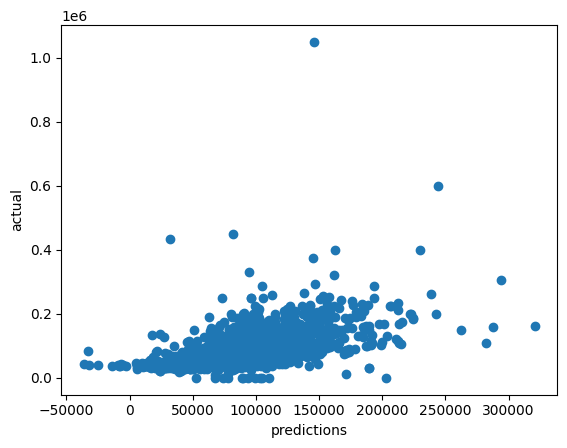

In [72]:
preds = model.predict(X_test)

#from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, preds)
import matplotlib.pyplot as plt

# Sample data

# Create a scatter plot
plt.scatter(preds, y_test)

# Add labels and title
plt.xlabel('predictions')
plt.ylabel('actual')

# Show the plot
plt.show()

In [73]:
len(preds)

1414